In [1]:
%config Completer.use_jedi = False

import sys
sys.path.append('..')

import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

use_cpu = False
cuda_device = '0'

if use_cpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    os.environ['CPU_ONLY'] = "TRUE"
    physical_devices = tf.config.list_physical_devices('CPU')
    tf.config.set_logical_device_configuration(
        physical_devices[0],
        [tf.config.LogicalDeviceConfiguration() for i in range(8)])
    logical_devices = tf.config.list_logical_devices('CPU')

    print(logical_devices)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = cuda_device
    os.environ['CPU_ONLY'] = "FALSE"
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    
from collections import defaultdict
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from tndm.data import DataManager
from tndm import LFADS
from tndm.runtime import Runtime, ModelType
from tndm.utils import AdaptiveWeights
from tndm.models.model_loader import ModelLoader

from sklearn.linear_model import Ridge

from plotting import *

2023-03-03 11:42:14.058799: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-03 11:42:14.059008: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[]


2023-03-03 11:42:18.921300: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-03 11:42:18.921871: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-03 11:42:18.921918: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-CCDKTVO2): /proc/driver/nvidia/version does not exist


In [2]:
# read the data/disk/scratch/cole/Chewie_CO_FF_2016-10-07_pos_M1_spikes/test_data/
spike_data_dir = "Chewie_CO_FF_2016-10-07_pos_M1_spikes/"

data_dir = os.path.join( spike_data_dir )

dataset, settings = DataManager.load_dataset(
    directory=data_dir,
    filename='dataset.h5')

# test set is combined valid and test
neural_data = dataset['train_data'].astype('float')
valid_neural_data = dataset['valid_data'].astype('float')
test_neural_data = dataset['test_data'].astype('float')

behavioural_data = dataset['train_behaviours'].astype('float')
valid_behavioural_data = dataset['valid_behaviours'].astype('float')
test_behavioural_data = dataset['test_behaviours'].astype('float')

# center behaviour at zero, using first time step (not strictly required)
b_mean = np.mean(np.vstack((behavioural_data, test_behavioural_data, valid_behavioural_data))[:,0,:],axis=0)
for i in range(2):
    behavioural_data[:,:,i] = behavioural_data[:,:,i]-b_mean[i]
    valid_behavioural_data[:,:,i] = valid_behavioural_data[:,:,i]-b_mean[i]
    test_behavioural_data[:,:,i] = test_behavioural_data[:,:,i]-b_mean[i]

# for plotting
d_all = np.concatenate((dataset['train_target_direction'], dataset['test_target_direction'], dataset['valid_target_direction']))
d = dataset['train_target_direction']
direction_index_train = np.array([sorted(set(d_all)).index(i) for i in d])
d = dataset['test_target_direction']
direction_index_test = np.array([sorted(set(d_all)).index(i) for i in d])
direction_index_all = np.concatenate((direction_index_test, direction_index_train))

In [3]:
# model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = .1
initial_neural_weight = 1.0 # weight of neural nll
initial_behaviour_weight = .2 # weight of behaviour loss
lambda_q = 100.0
update_rate = .0005
dropout = .15
seed = 0
GRU_pre_activation = False
var_min = 0.0001
prior_variance = 1

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-2,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08)

layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['encoder'].update(dict(var_min=var_min, var_trainable=True))
layers_settings['decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    

In [4]:
T = datetime.today().strftime("%y_%m_%d_%X")

logdir = os.path.join( spike_data_dir, 'lfads_log_l2_reg_'+str(l2_reg)+'_'+T)
modeldir = os.path.join( spike_data_dir, 'lfads_model_l2_reg_'+str(l2_reg)+'_'+T)

In [5]:
T0 = datetime.now()

model, history = Runtime.train(
    model_type=ModelType.LFADS,
    adaptive_lr=dict(factor=0.95, patience=10, min_lr=1e-5),
    model_settings=dict(
        factors=4,
        encoded_dim=64,
        max_grad_norm=200,
        dropout=dropout,
        prior_variance=prior_variance,
        GRU_pre_activation=GRU_pre_activation, #NEW
        timestep=settings['step'],
        seed=seed
    ),
    layers_settings=layers_settings,
    optimizer=optimizer, 
    epochs=10, 
    logdir=logdir,
    train_dataset=(neural_data, behavioural_data), 
    val_dataset=(valid_neural_data, valid_behavioural_data),
    adaptive_weights=AdaptiveWeights(
        initial=[initial_neural_weight, initial_behaviour_weight, .0, .0, lambda_q, .0], #changed
        update_start=[0, 0, 0, 1000, 1000, 0],
        update_rate=[0., 0., update_rate, update_rate, 0.0, update_rate],
        min_weight=[initial_neural_weight, initial_behaviour_weight, 0.0, 0.0, lambda_q, 0.0],#changed
        max_weight=[initial_neural_weight, initial_behaviour_weight, 1.0, 1.0, lambda_q, 1.0],#changed
    ),
    batch_size=16,
    verbose=0 # set to 2 to see the losses during training
)

model.save(modeldir)

print('Training took '+str(datetime.now()-T0))

2022-10-23 17:40:23.878502: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/xliu1626/miniconda3/envs/Gau_off/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


no sampling no logvar 1 no return state
no sampling no logvar 1 no return state
no sampling no logvar 1 no return state
no sampling no logvar 1 no return state
no sampling no logvar 1 no return state
no sampling no logvar 1 no return state
no sampling no logvar 1 no return state
no sampling no logvar 1 no return state
no sampling no logvar 1 no return state
no sampling no logvar 1 no return state
no sampling no logvar 1 no return state
no sampling no logvar 1 no return state
no sampling no logvar 1 no return state
no sampling no logvar 1 no return state
no sampling no logvar 1 no return state
no sampling no logvar 1 no return state
no sampling no logvar 1 no return state
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/xliu1626/miniconda3/envs/Gau_off/lib/python3.7/site-packages/keras/ba

In [5]:
modeldir = os.path.join( spike_data_dir, 'lfads_model_l2_reg_'+str(l2_reg)+'_'+'22_07_28_10:15:24')
print(modeldir)
model = ModelLoader.load(modeldir, model_class=LFADS)

Chewie_CO_FF_2016-10-07_pos_M1_spikes/lfads_model_l2_reg_0.1_22_07_28_10:15:24


2023-03-03 11:42:34.591368: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Latent space

## Training data

In [6]:
log_f, (g0, mean), z =  model(neural_data.astype('float'), training=False)
model.summary()

no sampling no logvar 1 no return state
Model: "lfads"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           multiple                  0         
                                                                 
 EncoderRNN (Bidirectional)  multiple                  52224     
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 DenseMean (Dense)           multiple                  8256      
                                                                 
 DenseLogVar (Dense)         multiple                  0 (unused)
                                                                 
 activation (Activati

Text(0.5, 1.0, 'Factors')

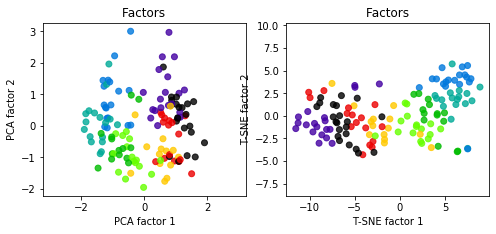

In [7]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(8,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(mean)
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('PCA factor 1')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(mean)
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('T-SNE factor 1')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


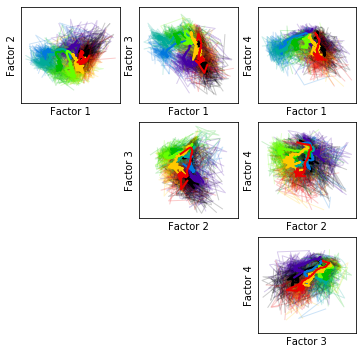

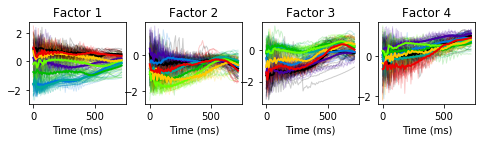

In [8]:
# latent factors
plt.figure(figsize=(6,6))
plot_all_2factors(z, direction_index_train)
plt.figure(figsize=(8,1.5))
plot_all_1factors(z, direction_index_train)


In [9]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]

0.9211995839834803


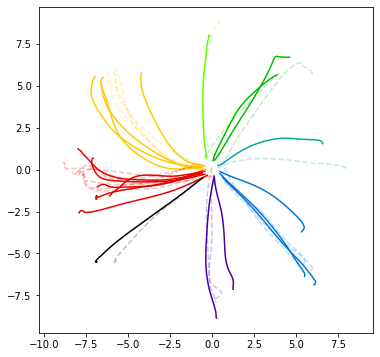

In [10]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b, behavioural_data, direction_index_train, num=20)

In [11]:
Xt = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
yt = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 92.120%


## Test data

In [12]:
log_f_t, (g0_t, logvar_t), z_t = \
    model(test_neural_data.astype('float'), training=False)
model.summary()
print(tf.is_tensor(log_f_t))
print(tf.is_tensor(g0_t))
print(tf.is_tensor(logvar_t))
print(tf.is_tensor(z_t))

no sampling no logvar 1 no return state
Model: "lfads"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           multiple                  0         
                                                                 
 EncoderRNN (Bidirectional)  multiple                  52224     
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 DenseMean (Dense)           multiple                  8256      
                                                                 
 DenseLogVar (Dense)         multiple                  0 (unused)
                                                                 
 activation (Activati

NameError: name 'mean_t' is not defined

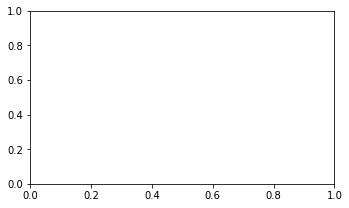

In [13]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(12,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


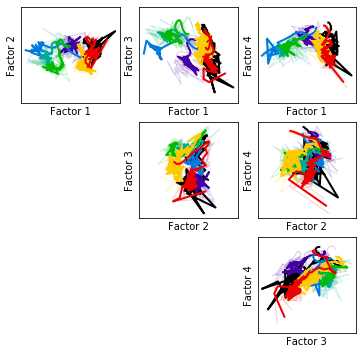

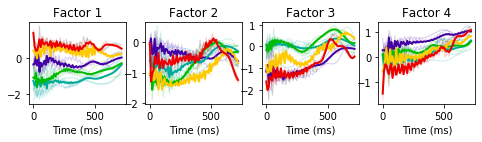

In [14]:
# relevant factors
plt.figure(figsize=(6,6))
plot_all_2factors(z_t, direction_index_test)
# relevant factors
plt.figure(figsize=(8,1.5))
plot_all_1factors(z_t, direction_index_test)


In [15]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = np.transpose(z_t.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b_t = np.zeros_like(test_behavioural_data)
b_t[:,:,0] = beh_fit[:,:test_behavioural_data.shape[1]]
b_t[:,:,1] = beh_fit[:,test_behavioural_data.shape[1]:]

0.8704878303881382


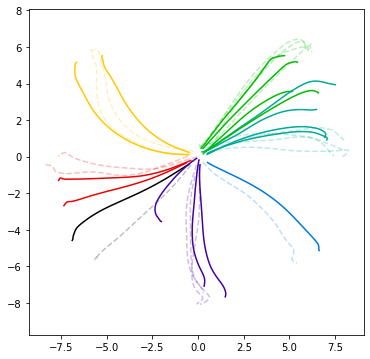

In [16]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b_t, test_behavioural_data, direction_index_test, num=100)
# plot_behaviour(b, behavioural_data, direction_index_train)

In [17]:
Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 87.049%


# Trial-averaged firing rates and predictions
Computed from test+train data for better averages

In [ ]:
from sklearn.metrics import mean_squared_error
fig = plt.figure(figsize=(16,10))
colors = plt.cm.nipy_spectral(np.arange(8)/8)
a = []
for i in range(8):
    data = np.vstack((test_neural_data, neural_data))[direction_index_all==i,:,:]

    for i_n,n in enumerate(range(0,70)):
        ax = fig.add_subplot(8, 70, i*70+i_n+1)
        pred = np.vstack((np.exp(log_f_t)*settings['step'], np.exp(log_f)*settings['step']))[np.array(direction_index_all)==i,:,n]
        x = np.arange(data.shape[1])
        ax.plot(x,np.mean(data,axis=0)[:,n],'k',alpha=0.5);
        data_mean = np.mean(data,axis=0)
        data_mean_test = np.mean(data,axis=0)[:,n]
#         print("n",n)
#         print(pred.shape)
#         print(data_mean_test.shape)
        
        ax.fill_between(x,np.mean(data,axis=0)[:,n]-np.std(data,axis=0)[:,n], np.mean(data,axis=0)[:,n]+np.std(data,axis=0)[:,n], alpha=0.2, color='k');
        ax.plot(x,np.mean(pred,axis=0),lw=3, color=colors[i]);
        pred_test = np.mean(pred,axis=0)
#         print(pred_test.shape)

        ax.set_xticks(())
        ax.set_yticks(())
        plt.ylim(0,1.5)
        
        data4mse = data_mean_test
        pred4mse = pred_test
        diff = mean_squared_error(data4mse,pred4mse)
        a.append(diff)
        


# Recreate LFADs in keras functional API

In [18]:
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Flatten, GRU, Activation, Embedding, Bidirectional 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import Model

In [19]:
inputs2model = neural_data # 17, 73, 70
print(inputs2model.shape[0])
inputs2decoder = 

136


In [20]:
initializer = tf.keras.initializers.VarianceScaling(distribution='normal')
regularizer = tf.keras.regularizers.L2(l=1)
inputs2model = neural_data # 136, 73, 70
inputDim = 136
inputs2decoder = tf.stack([tf.zeros_like(inputs2model)[:, :, -1]
            for i in range(64)], axis=-1)
# inputs2decoder = np.zeros((17,73,64))
def create_model(inputs2model, inputs2decoder, initializer, regularizer):
  
  inputLayer =  Input(shape=inputs2model[0].shape)
  x = Dropout(0.05, name = 'initial_dropout')(inputLayer)
  x = Bidirectional(GRU(64, time_major=False, 
                        return_state=True, kernel_regularizer=regularizer, 
                        kernel_initializer=initializer), 
                    backward_layer=GRU(64, time_major=False, 
                                       return_state=True, go_backwards=True, 
                                       kernel_regularizer=regularizer, kernel_initializer=initializer), 
                    merge_mode='concat', name = 'Encoder_BidirectionalGRU')(x)[0]
  x = Dropout(0.05, name = 'postencoder_dropout')(x)
  x = Dense(64, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense_mean')(x)
  input_decoder = Input(shape=inputs2decoder[0].shape)
  x = GRU(64, return_sequences=True, 
          time_major=False, kernel_initializer=initializer, 
          kernel_regularizer=regularizer, name='decoder_GRU')(input_decoder, initial_state = x)
  x = Dropout(0.05, name = 'postdecoder_dropout')(x)
  z = Dense(4, use_bias = False, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense')(x)
  log_f = Dense(70, kernel_regularizer=regularizer, kernel_initializer=initializer, name='nerual_dense')(z)
  return Model(inputs = [inputLayer,input_decoder], outputs =[z, log_f])

keras_model_1 = create_model(inputs2model,inputs2decoder, initializer, regularizer)
keras_model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['input_1[0][0]']                
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                              

In [21]:
keras_model_1.compile()
keras_model_1.layers[2].set_weights(model.layers[1].get_weights())
keras_model_1.layers[5].set_weights(model.layers[4].get_weights())
keras_model_1.layers[6].set_weights(model.layers[7].get_weights())
keras_model_1.layers[8].set_weights(model.layers[8].get_weights())
keras_model_1.layers[9].set_weights(model.layers[9].get_weights())

In [35]:
# train_data = (neural_data, behavioural_data)
# val_data = (valid_neural_data, valid_behavioural_data)
# (train_, behav_), val = Runtime.clean_datasets(train_data, val_data, LFADS)

In [36]:
# (train_, behav_), val = Runtime.clean_datasets(train_data, val_data, LFADS)
# print(behav_.shape)

# train_ = train_[0:128,:,:]
# behav_ = behav_[0:128,:,:]
# print(train_.shape)

In [22]:
saved_model_dir = "Saved_model/"
model_dir = os.path.join(saved_model_dir, '3_3.h5')
keras_model_1.save(model_dir)
reconstructed_model = tf.keras.models.load_model(model_dir)

In [24]:
inputs2decoder_test = tf.stack([tf.zeros_like(test_neural_data)[:, :, -1]
        for i in range(64)], axis=-1)

In [25]:
new_z, new_log_f = reconstructed_model.predict([test_neural_data,inputs2decoder_test])

In [30]:
z_n = z_t.numpy()
log_f_n = log_f_t.numpy()

In [37]:
# print(tf.math.equal(new_z,z_t))
# print(tf.math.equal(new_log_f,log_f_t))

In [32]:
dict_a = Runtime.evaluate_performance(model, test_neural_data.astype('float'), test_behavioural_data.astype('float'), z_n)
print(dict_a)

no sampling no logvar 1 no return state
({'behaviour_likelihood': None, 'neural_likelihood': -1812.3318014705883, 'behaviour_r2': None, 'latent_r2': 0.9999936197783285}, Ridge())


In [34]:
dict_a = Runtime.evaluate_performance(model, test_neural_data.astype('float'), test_behavioural_data.astype('float'), new_z)
print(dict_a)

no sampling no logvar 1 no return state
({'behaviour_likelihood': None, 'neural_likelihood': -1812.3318014705883, 'behaviour_r2': None, 'latent_r2': 0.9999936197783285}, Ridge())


# Ignore The Code Below

In [87]:
keras_model_1.compile()
keras_model_1.layers[2].set_weights(model.layers[1].get_weights())
keras_model_1.layers[4].set_weights(model.layers[4].get_weights())
keras_model_1.layers[5].set_weights(model.layers[7].get_weights())
keras_model_1.layers[7].set_weights(model.layers[8].get_weights())
keras_model_1.layers[8].set_weights(model.layers[9].get_weights())

In [23]:
# print((model.layers[1].get_weights()))
# print(keras_model_1.layers[2].get_weights())

In [19]:
saved_model_dir = "Saved_model/"
model_dir = os.path.join(saved_model_dir, 'test_compile1.h5')
keras_model_1.save(model_dir)
reconstructed_model = tf.keras.models.load_model(model_dir)

In [24]:
# reconstructed_model = tf.keras.models.load_model(model_dir)

In [42]:
# new_z, new_log_f = keras_model_1.predict(test_neural_data)
# new_z = new_z.numpy()

In [19]:
def create_model(inputs2model, initializer, regularizer):
  
  inputLayer = x_in = Input(shape=inputs2model[0].shape)
  x = Dropout(0.05, name = 'initial_dropout')(inputLayer)
#   x = Bidirectional(GRU(64, time_major=False, 
#                         return_state=True, kernel_regularizer=regularizer, 
#                         kernel_initializer=initializer), 
#                     backward_layer=GRU(64, time_major=False, 
#                                        return_state=True, go_backwards=True, 
#                                        kernel_regularizer=regularizer, kernel_initializer=initializer), 
#                     merge_mode='concat', name = 'Encoder_BidirectionalGRU')(x)[0]
#   x = GRU(64, time_major=False, 
#                         return_state=True, kernel_regularizer=regularizer, 
#                         kernel_initializer=initializer)(x)
  x = GRU(64)(x)
  x = Dropout(0.05, name = 'postencoder_dropout')(x)
  x = Dense(64, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense_mean')(x)
  inputs2decoder = tf.stack([tf.zeros_like(inputs2model)[:, :, -1]
            for i in range(64)], axis=-1)
#   x = GRU(64, return_sequences=True, 
#           time_major=False, kernel_initializer=initializer, 
#           kernel_regularizer=regularizer, name='decoder_GRU')(inputs2decoder, initial_state = x)
  x = Dropout(0.05, name = 'postdecoder_dropout')(x)
  z = Dense(4, use_bias = False, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense')(x)
  log_f = Dense(70, kernel_regularizer=regularizer, kernel_initializer=initializer, name='nerual_dense')(z)
  return Model(inputs = [inputLayer, input2decoder]outputs =[z, log_f])

keras_model = create_model(inputs2model, initializer, regularizer)
keras_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 73, 70)]          0         
                                                                 
 initial_dropout (Dropout)   (None, 73, 70)            0         
                                                                 
 gru_2 (GRU)                 (None, 64)                26112     
                                                                 
 postencoder_dropout (Dropou  (None, 64)               0         
 t)                                                              
                                                                 
 dense_mean (Dense)          (None, 64)                4160      
                                                                 
 postdecoder_dropout (Dropou  (None, 64)               0         
 t)                                                        

In [16]:
new_z, new_log_f = keras_model.predict(test_neural_data)

In [ ]:
# import hls4ml
# config = hls4ml.utils.config_from_keras_model(keras_model, granularity='model')
# print("-----------------------------------")
# print("Configuration")
# plotting.print_dict(config)
# print("-----------------------------------")
# hls_model = hls4ml.converters.convert_from_keras_model(model,
#                                                        hls_config=config,
#                                                        output_dir='model_1/hls4ml_prj',
#                                                        part='xcu250-figd2104-2L-e')

In [17]:
keras_model.layers[2].set_weights(model.layers[1].get_weights())
keras_model.layers[5].set_weights(model.layers[4].get_weights())
keras_model.layers[6].set_weights(model.layers[7].get_weights())
keras_model.layers[8].set_weights(model.layers[8].get_weights())
keras_model.layers[9].set_weights(model.layers[9].get_weights())

In [18]:
saved_model_dir = "Saved_model/"
model_dir = os.path.join(saved_model_dir, '2_8.h5')
keras_model.save(model_dir)

In [19]:
reconstructed_model = tf.keras.models.load_model(model_dir)

In [18]:
inputs2decoder = tf.stack([tf.zeros_like(test_neural_data)[:, :, -1]
        for i in range(64)], axis=-1)

In [19]:
print(test_neural_data.shape)
print(inputs2decoder.shape)

(17, 73, 70)
(17, 73, 64)


In [22]:
new_z_t, new_log_f_t = reconstructed_model.predict([test_neural_data, inputs2decoder])
# new_z_n = new_z_t.numpy()
z_n = z_t.numpy()

In [27]:
dict_a = Runtime.evaluate_performance(model, test_neural_data.astype('float'), test_behavioural_data.astype('float'), z_n)
print(dict_a)

no sampling no logvar 1 no return state
({'behaviour_likelihood': None, 'neural_likelihood': -1812.3318014705883, 'behaviour_r2': None, 'latent_r2': 0.9999936197783285}, Ridge())


In [24]:
dict_a = Runtime.evaluate_performance(model, test_neural_data.astype('float'), test_behavioural_data.astype('float'), new_z_t)
print(dict_a)

no sampling no logvar 1 no return state
({'behaviour_likelihood': None, 'neural_likelihood': -1812.3318014705883, 'behaviour_r2': None, 'latent_r2': 0.9999936197783285}, Ridge())


In [41]:
# print(test_neural_data[1].shape)
# new_z, new_log_f = keras_model.predict(test_neural_data)
# print(tf.is_tensor(new_z))
# print(tf.is_tensor(new_log_f))
# new_z = tf.convert_to_tensor(new_z)
# new_log_f = tf.convert_to_tensor(new_log_f
# print(tf.math.equal(new_z_t,z_t))
# test = tf.constant(tf.math.equal(new_z_t,z_t))
# if_true = tf.math.count_nonzero(test)
# zero = tf.constant(0)
# print(if_true)
# print(tf.not_equal(if_true, zero))
# print(z_t.shape)
# print(tf.math.equal(new_log_f_t,log_f_t))

In [26]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = np.transpose(new_z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((new_z.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b_t = np.zeros_like(test_behavioural_data)
b_t[:,:,0] = beh_fit[:,:test_behavioural_data.shape[1]]
b_t[:,:,1] = beh_fit[:,test_behavioural_data.shape[1]:]

0.8778394771886708


In [ ]:
neural_data = dataset['train_data'].astype('float')
valid_neural_data = dataset['valid_data'].astype('float')
test_neural_data = dataset['test_data'].astype('float')

behavioural_data = dataset['train_behaviours'].astype('float')
valid_behavioural_data = dataset['valid_behaviours'].astype('float')
test_behavioural_data = dataset['test_behaviours'].astype('float')

In [12]:
print(neural_data[0].shape)

(73, 70)


In [27]:

from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from numpy import array
# define model
inputs1 = Input(shape=(5,2))
lstm1 = LSTM(1, return_sequences=True)(inputs1)
model = Model(inputs=inputs1, outputs=lstm1)
model.summary()
# define input data
data = array([0.1, 0.2, 0.3, 0.4, 0.5,0.1, 0.2, 0.3, 0.4, 0.5]).reshape((1,5,2))
# make and show prediction
print(model.predict(data))

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 5, 2)]            0         
                                                                 
 lstm_12 (LSTM)              (None, 5, 1)              16        
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
[[[0.03444481]
  [0.10220274]
  [0.13873701]
  [0.16433707]
  [0.21475308]]]


In [1]:
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Flatten, GRU, Activation, Embedding, Bidirectional 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import Model
import numpy as np

2022-10-25 13:01:49.578697: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-25 13:01:49.579108: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
initializer = tf.keras.initializers.VarianceScaling(distribution='normal')
regularizer = tf.keras.regularizers.L2(l=1)

def create_model(inputs2model, initializer, regularizer):
  
  inputLayer = x_in = Input(shape=inputs2model[0].shape)
  temp = Dropout(0.05, name = 'initial_dropout')(inputLayer)
  x = GRU(64, return_sequences= True,kernel_regularizer=regularizer, kernel_initializer=initializer)(temp)
  x = GRU(64, return_sequences= True, kernel_regularizer=regularizer, kernel_initializer=initializer)(x)
  temp_1 = Dropout(0.05, name = 'postencoder_dropout')(x)
  x = Dense(64, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense_mean')(temp_1)
  x = GRU(64, return_sequences=True, kernel_initializer=initializer, 
          kernel_regularizer=regularizer, name='decoder_GRU')(x)
  x = Dropout(0.05, name = 'postdecoder_dropout')(x)
  z = Dense(4, use_bias = False, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense')(x)
  log_f = Dense(70, kernel_regularizer=regularizer, kernel_initializer=initializer, name='nerual_dense')(z)
  return Model(inputs = inputLayer, outputs =[z, log_f])

inputs2model = np.zeros((136,73,70)) # 136, 73, 70
fake_LFADs = create_model(inputs2model, initializer, regularizer)

fake_LFADs.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 73, 70)]          0         
                                                                 
 initial_dropout (Dropout)   (None, 73, 70)            0         
                                                                 
 gru_2 (GRU)                 (None, 73, 64)            26112     
                                                                 
 gru_3 (GRU)                 (None, 73, 64)            24960     
                                                                 
 postencoder_dropout (Dropou  (None, 73, 64)           0         
 t)                                                              
                                                                 
 dense_mean (Dense)          (None, 73, 64)            4160      
                                                           